# DeepGuard - Data Exploration & Preprocessing Experiments

This notebook explores the CIFAKE dataset (Real vs AI-Generated Images) and sets up MLflow tracking with DagsHub.

**Dataset**: CIFAKE - Real and AI-Generated Synthetic Images  
**Source**: Kaggle - https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images

## 1. Setup & Dependencies

In [6]:
# Install required packages (uncomment and run if needed)
! pip install dagshub mlflow tensorflow opencv-python matplotlib seaborn pandas numpy scikit-learn pillow opendatasets

  Using cached python_slugify-8.0.4-py2.py3-none-any.whl.metadata (8.5 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl.metadata (2.4 kB)
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.4 MB 8.5 MB/s eta 0:00:01
   ----------------------------- ---------- 1.0/1.4 MB 2.5 MB/s eta 0:00:01
   ----------------------------- ---------- 1.0/1.4 MB 2.5 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 1.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/10.1 MB ? eta -:--:--
   ----- ---------------------------------- 1.3/10.1 MB 9.5 MB/s eta 0:00:01
   ----- ---------------------------------- 1.3/10.1 MB 9.5 MB/s eta 0:00:01
   ----------- ---------------------------- 2.9/10.1 MB 4.9 MB/s eta 0:00:02
   --------------- ------------------------ 3.9/10.1 MB 5.6 MB/s eta 0:00:02
   ------------------ --------------------- 4.7/10.1 MB 4.7 MB/s eta 0:00:02
   ---------------------


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
import shutil
import zipfile
import warnings
warnings.filterwarnings('ignore')

# MLflow & DagsHub Integration
import mlflow
import dagshub

print("All imports successful!")

All imports successful!


## 2. Download CIFAKE Dataset from Kaggle

**Option 1**: Using `opendatasets` (Recommended - will prompt for Kaggle credentials)

**Option 2**: Using Kaggle API (requires kaggle.json setup)

**First time setup**:
1. Go to https://www.kaggle.com/settings → Create New Token
2. This downloads `kaggle.json` with your credentials
3. Enter username and key when prompted below

In [8]:
# Install opendatasets for easy Kaggle download
! pip install opendatasets -q


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import opendatasets as od

# Dataset URL
DATASET_URL = "https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images"

# Download directory
DOWNLOAD_DIR = "../data/raw"

# Create directory if not exists
os.makedirs(DOWNLOAD_DIR, exist_ok=True)

# Download dataset (will prompt for Kaggle username and API key)
print("📥 Downloading CIFAKE dataset from Kaggle...")
print("You'll be prompted for your Kaggle credentials.")
print("Get your API key from: https://www.kaggle.com/settings → Create New Token\n")

od.download(DATASET_URL, data_dir=DOWNLOAD_DIR)

In [ ]:
# Verify and organize the downloaded data
DOWNLOAD_PATH = Path(DOWNLOAD_DIR) / "cifake-real-and-ai-generated-synthetic-images"
TARGET_PATH = Path(DOWNLOAD_DIR) / "cifake"

# Check what was downloaded
if DOWNLOAD_PATH.exists():
    print(f"✅ Dataset downloaded to: {DOWNLOAD_PATH}")
    print("\nContents:")
    for item in DOWNLOAD_PATH.iterdir():
        print(f"  - {item.name}")
    
    # Rename to simpler path if needed
    if not TARGET_PATH.exists():
        shutil.move(str(DOWNLOAD_PATH), str(TARGET_PATH))
        print(f"\n📁 Moved to: {TARGET_PATH}")
else:
    print("❌ Download path not found. Please check download.")

In [17]:
# Alternative: Manual extraction if downloaded as zip
def extract_dataset_if_zip():
    """Extract dataset if it was downloaded as a zip file."""
    raw_dir = Path("../data/raw")
    
    # Look for any zip files
    zip_files = list(raw_dir.glob("*.zip"))
    
    for zip_path in zip_files:
        print(f"📦 Found zip file: {zip_path}")
        extract_dir = raw_dir / "cifake"
        
        if not extract_dir.exists():
            print(f"📂 Extracting to: {extract_dir}")
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_dir)
            print("✅ Extraction complete!")
        else:
            print(f"✅ Already extracted at: {extract_dir}")

# Run extraction if needed
extract_dataset_if_zip()

## 3. DagsHub + MLflow Configuration

Replace the values below with your DagsHub repository details.

In [ ]:
# DagsHub MLflow Integration
# Update these with your DagsHub credentials
DAGSHUB_USERNAME = "your-username"  # Replace with your DagsHub username
DAGSHUB_REPO_NAME = "DeepGuard-MLOps-Pipeline"  # Your repo name
DAGSHUB_TOKEN = "your-token"  # Your DagsHub token (from Step 32 in project_flow.txt)

# Initialize DagsHub
dagshub.init(repo_owner=DAGSHUB_USERNAME, repo_name=DAGSHUB_REPO_NAME, mlflow=True)

# Set MLflow tracking URI
mlflow.set_tracking_uri(f"https://dagshub.com/{DAGSHUB_USERNAME}/{DAGSHUB_REPO_NAME}.mlflow")

print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")

Initialized MLflow to track repo "pythonharsh1234/DeepGuard-MLOps-Pipeline"

Repository pythonharsh1234/DeepGuard-MLOps-Pipeline initialized!

MLflow Tracking URI: https://dagshub.com/pythonharsh1234/DeepGuard-MLOps-Pipeline.mlflow


## 4. Verify Dataset Structure

In [19]:
# Define dataset paths
DATA_DIR = Path("../data/raw/cifake")
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR = DATA_DIR / "test"

# Check if dataset exists
if DATA_DIR.exists():
    print(f"✅ Dataset found at: {DATA_DIR}")
    print(f"\n📁 Directory structure:")
    
    for item in DATA_DIR.rglob("*"):
        if item.is_dir():
            depth = len(item.relative_to(DATA_DIR).parts)
            indent = "  " * depth
            print(f"{indent}📂 {item.name}/")
else:
    print("❌ Dataset not found! Run the download cells above.")
    print("\nExpected structure:")
    print("  data/raw/cifake/")
    print("  ├── train/")
    print("  │   ├── REAL/")
    print("  │   └── FAKE/")
    print("  └── test/")
    print("      ├── REAL/")
    print("      └── FAKE/")

✅ Dataset found at: ..\data\raw\cifake

📁 Directory structure:
  📂 test/
  📂 train/
    📂 FAKE/
    📂 REAL/
    📂 FAKE/
    📂 REAL/


## 5. Data Exploration

In [20]:
def count_images(directory):
    """Count images in each class folder."""
    counts = {}
    if directory.exists():
        for class_dir in directory.iterdir():
            if class_dir.is_dir():
                count = len(list(class_dir.glob("*.png"))) + len(list(class_dir.glob("*.jpg")))
                counts[class_dir.name] = count
    return counts

# Count training and test images
train_counts = count_images(TRAIN_DIR)
test_counts = count_images(TEST_DIR)

print("\n📊 Dataset Statistics:")
print("=" * 40)
print(f"Training Set: {train_counts}")
print(f"Test Set: {test_counts}")
print(f"Total Training: {sum(train_counts.values()) if train_counts else 0}")
print(f"Total Test: {sum(test_counts.values()) if test_counts else 0}")


📊 Dataset Statistics:
Training Set: {'FAKE': 50000, 'REAL': 50000}
Test Set: {'FAKE': 10000, 'REAL': 10000}
Total Training: 100000
Total Test: 20000


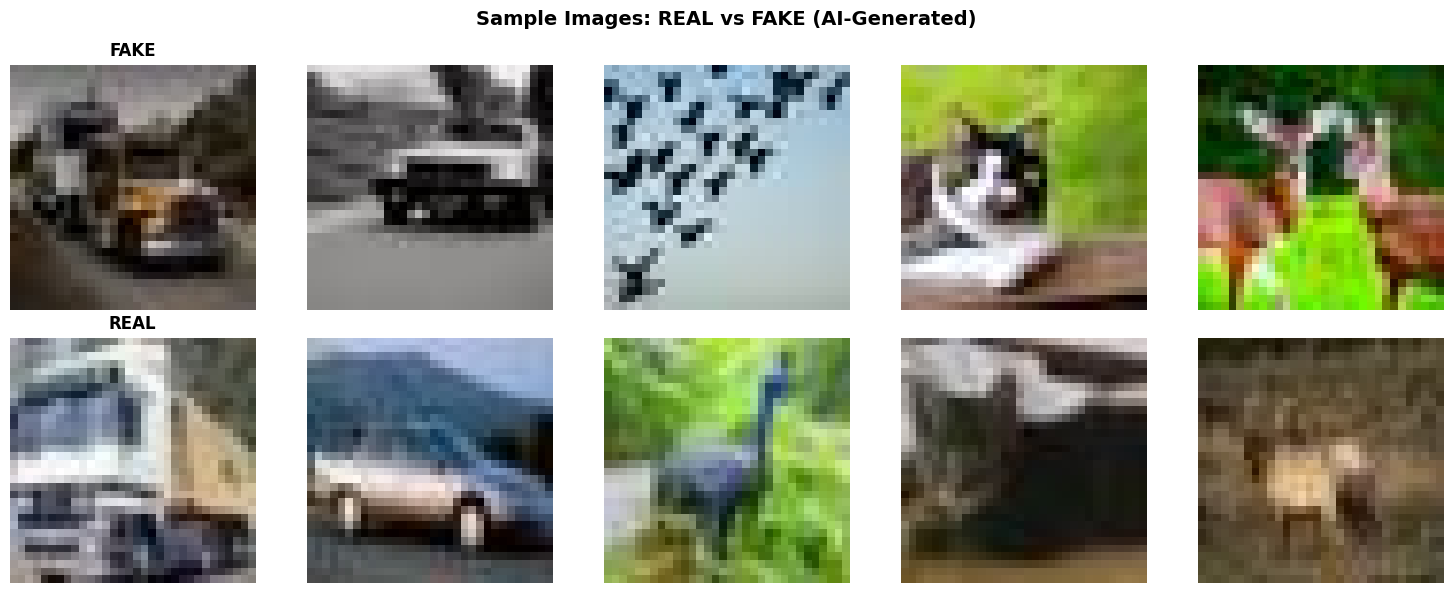

In [21]:
def load_sample_images(directory, n_samples=5):
    """Load sample images from each class."""
    samples = {}
    if directory.exists():
        for class_dir in directory.iterdir():
            if class_dir.is_dir():
                images = list(class_dir.glob("*.png"))[:n_samples]
                if not images:
                    images = list(class_dir.glob("*.jpg"))[:n_samples]
                samples[class_dir.name] = [Image.open(img) for img in images]
    return samples

# Load and display sample images
samples = load_sample_images(TRAIN_DIR, n_samples=5)

if samples:
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle("Sample Images: REAL vs FAKE (AI-Generated)", fontsize=14, fontweight='bold')
    
    for idx, (class_name, images) in enumerate(samples.items()):
        for j, img in enumerate(images):
            axes[idx, j].imshow(img)
            axes[idx, j].axis('off')
            if j == 0:
                axes[idx, j].set_title(f"{class_name}", fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    os.makedirs("../reports/figures", exist_ok=True)
    plt.savefig("../reports/figures/sample_images.png", dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No sample images loaded. Please ensure dataset is downloaded.")

## 6. Image Statistics Analysis

In [22]:
def analyze_image_properties(directory, sample_size=100):
    """Analyze image properties like size, color distribution, etc."""
    stats = []
    
    if not directory.exists():
        return pd.DataFrame()
    
    for class_dir in directory.iterdir():
        if class_dir.is_dir():
            images = list(class_dir.glob("*.png"))[:sample_size]
            if not images:
                images = list(class_dir.glob("*.jpg"))[:sample_size]
            
            for img_path in images:
                img = Image.open(img_path)
                img_array = np.array(img)
                
                stats.append({
                    'class': class_dir.name,
                    'width': img.size[0],
                    'height': img.size[1],
                    'mean_r': img_array[:,:,0].mean() if len(img_array.shape) == 3 else img_array.mean(),
                    'mean_g': img_array[:,:,1].mean() if len(img_array.shape) == 3 else img_array.mean(),
                    'mean_b': img_array[:,:,2].mean() if len(img_array.shape) == 3 else img_array.mean(),
                    'std_r': img_array[:,:,0].std() if len(img_array.shape) == 3 else img_array.std(),
                    'std_g': img_array[:,:,1].std() if len(img_array.shape) == 3 else img_array.std(),
                    'std_b': img_array[:,:,2].std() if len(img_array.shape) == 3 else img_array.std(),
                })
    
    return pd.DataFrame(stats)

# Analyze training images
df_stats = analyze_image_properties(TRAIN_DIR, sample_size=200)

if not df_stats.empty:
    print("\n📈 Image Statistics Summary:")
    print(df_stats.groupby('class').agg(['mean', 'std']).round(2))
else:
    print("No statistics computed. Dataset not found.")


📈 Image Statistics Summary:
      width      height       mean_r         mean_g         mean_b         \
       mean  std   mean  std    mean    std    mean    std    mean    std   
class                                                                       
FAKE   32.0  0.0   32.0  0.0  114.83  18.40  112.90  22.18   96.52  40.82   
REAL   32.0  0.0   32.0  0.0  123.92  30.52  121.85  31.15  112.16  36.02   

       std_r         std_g         std_b         
        mean    std   mean    std   mean    std  
class                                            
FAKE   52.23  14.75  52.53  15.24  52.35  16.37  
REAL   51.22  14.29  49.76  14.54  50.36  15.24  


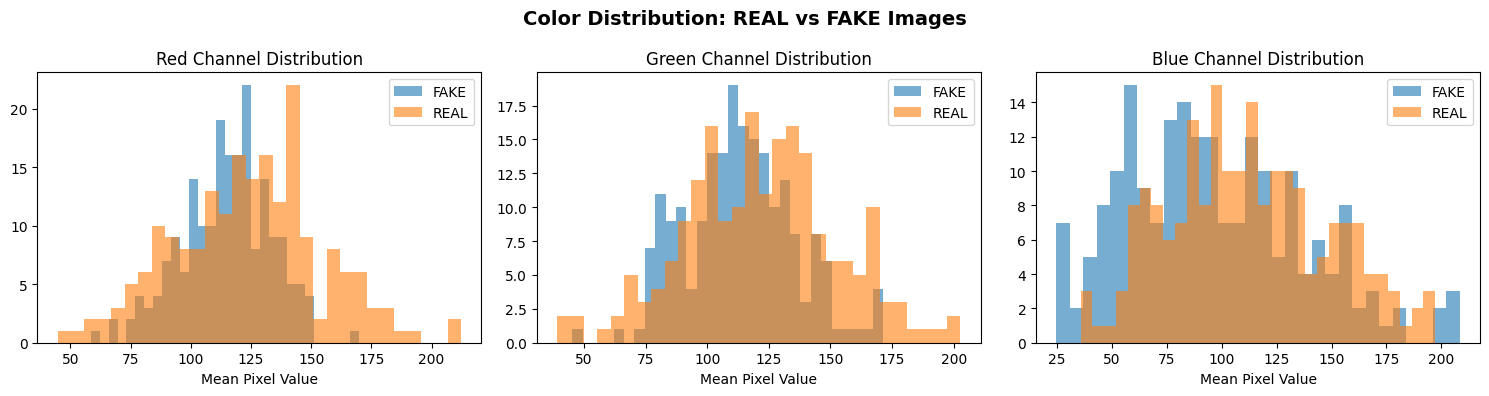

In [23]:
# Visualize color distribution differences
if not df_stats.empty:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    colors = ['Red', 'Green', 'Blue']
    cols = ['mean_r', 'mean_g', 'mean_b']
    
    for ax, col, color in zip(axes, cols, colors):
        for class_name in df_stats['class'].unique():
            data = df_stats[df_stats['class'] == class_name][col]
            ax.hist(data, alpha=0.6, label=class_name, bins=30)
        ax.set_title(f"{color} Channel Distribution")
        ax.set_xlabel("Mean Pixel Value")
        ax.legend()
    
    plt.suptitle("Color Distribution: REAL vs FAKE Images", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig("../reports/figures/color_distribution.png", dpi=150, bbox_inches='tight')
    plt.show()

## 7. MLflow Experiment: Data Preprocessing

In [24]:
# Set experiment name
mlflow.set_experiment("DeepGuard-Data-Exploration")

# Log exploration results
with mlflow.start_run(run_name="data_exploration_v1"):
    # Log dataset parameters
    mlflow.log_param("dataset_name", "CIFAKE")
    mlflow.log_param("dataset_source", "Kaggle")
    
    # Log dataset metrics
    if train_counts:
        mlflow.log_metric("train_real_count", train_counts.get('REAL', 0))
        mlflow.log_metric("train_fake_count", train_counts.get('FAKE', 0))
        mlflow.log_metric("train_total", sum(train_counts.values()))
    
    if test_counts:
        mlflow.log_metric("test_real_count", test_counts.get('REAL', 0))
        mlflow.log_metric("test_fake_count", test_counts.get('FAKE', 0))
        mlflow.log_metric("test_total", sum(test_counts.values()))
    
    # Log image statistics
    if not df_stats.empty:
        for class_name in df_stats['class'].unique():
            class_data = df_stats[df_stats['class'] == class_name]
            mlflow.log_metric(f"{class_name.lower()}_mean_r", class_data['mean_r'].mean())
            mlflow.log_metric(f"{class_name.lower()}_mean_g", class_data['mean_g'].mean())
            mlflow.log_metric(f"{class_name.lower()}_mean_b", class_data['mean_b'].mean())
    
    # Log artifacts (figures)
    figures_dir = Path("../reports/figures")
    if figures_dir.exists():
        for fig_path in figures_dir.glob("*.png"):
            mlflow.log_artifact(str(fig_path))
    
    print("✅ Data exploration experiment logged to MLflow!")
    print(f"Run ID: {mlflow.active_run().info.run_id}")

2025/12/13 12:51:19 INFO mlflow.tracking.fluent: Experiment with name 'DeepGuard-Data-Exploration' does not exist. Creating a new experiment.


✅ Data exploration experiment logged to MLflow!
Run ID: 294c8632a18f419a8ea5c16355537a06
🏃 View run data_exploration_v1 at: https://dagshub.com/pythonharsh1234/DeepGuard-MLOps-Pipeline.mlflow/#/experiments/0/runs/294c8632a18f419a8ea5c16355537a06
🧪 View experiment at: https://dagshub.com/pythonharsh1234/DeepGuard-MLOps-Pipeline.mlflow/#/experiments/0


## 8. Data Preprocessing Pipeline

In [25]:
import cv2

def preprocess_image(image_path, target_size=(128, 128)):
    """
    Preprocess a single image for model training.
    
    Args:
        image_path: Path to image file
        target_size: Target image dimensions (height, width)
    
    Returns:
        Preprocessed image array normalized to [0, 1]
    """
    # Read image
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize
    img = cv2.resize(img, target_size)
    
    # Normalize to [0, 1]
    img = img.astype(np.float32) / 255.0
    
    return img

def create_dataset(data_dir, target_size=(128, 128), max_samples=None):
    """
    Create dataset arrays from image directory.
    
    Args:
        data_dir: Path to data directory with class subfolders
        target_size: Target image size
        max_samples: Maximum samples per class (for quick testing)
    
    Returns:
        X: Image arrays
        y: Labels (0=REAL, 1=FAKE)
    """
    images = []
    labels = []
    label_map = {'REAL': 0, 'FAKE': 1}
    
    data_path = Path(data_dir)
    if not data_path.exists():
        print(f"Directory not found: {data_dir}")
        return np.array([]), np.array([])
    
    for class_name, label in label_map.items():
        class_dir = data_path / class_name
        if class_dir.exists():
            image_paths = list(class_dir.glob("*.png")) + list(class_dir.glob("*.jpg"))
            if max_samples:
                image_paths = image_paths[:max_samples]
            
            print(f"Processing {class_name}: {len(image_paths)} images...")
            for img_path in image_paths:
                try:
                    img = preprocess_image(img_path, target_size)
                    images.append(img)
                    labels.append(label)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
    
    return np.array(images), np.array(labels)

print("Preprocessing functions defined!")

Preprocessing functions defined!


In [26]:
# Create sample dataset (limited for quick testing)
print("Creating sample dataset...")
X_train_sample, y_train_sample = create_dataset(TRAIN_DIR, target_size=(128, 128), max_samples=500)
X_test_sample, y_test_sample = create_dataset(TEST_DIR, target_size=(128, 128), max_samples=100)

print(f"\n📦 Sample Dataset Shape:")
print(f"X_train: {X_train_sample.shape}")
print(f"y_train: {y_train_sample.shape}")
print(f"X_test: {X_test_sample.shape}")
print(f"y_test: {y_test_sample.shape}")

if len(y_train_sample) > 0:
    print(f"\nClass distribution (train): REAL={sum(y_train_sample==0)}, FAKE={sum(y_train_sample==1)}")

Creating sample dataset...
Processing REAL: 500 images...
Processing FAKE: 500 images...
Processing REAL: 100 images...
Processing FAKE: 100 images...

📦 Sample Dataset Shape:
X_train: (1000, 128, 128, 3)
y_train: (1000,)
X_test: (200, 128, 128, 3)
y_test: (200,)

Class distribution (train): REAL=500, FAKE=500


In [27]:
# Save preprocessed sample data for quick experiments
PROCESSED_DIR = Path("../data/processed")
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

if len(X_train_sample) > 0:
    np.save(PROCESSED_DIR / "X_train_sample.npy", X_train_sample)
    np.save(PROCESSED_DIR / "y_train_sample.npy", y_train_sample)
    np.save(PROCESSED_DIR / "X_test_sample.npy", X_test_sample)
    np.save(PROCESSED_DIR / "y_test_sample.npy", y_test_sample)
    print(f"✅ Sample data saved to {PROCESSED_DIR}")
else:
    print("No data to save. Please download the dataset first.")

✅ Sample data saved to ..\data\processed


## 9. Summary

In this notebook, we:
1. ✅ Downloaded CIFAKE dataset from Kaggle
2. ✅ Set up DagsHub + MLflow integration
3. ✅ Explored the dataset structure
4. ✅ Analyzed image statistics (color distributions)
5. ✅ Created preprocessing pipeline
6. ✅ Logged exploration experiment to MLflow

**Next Steps**: Run `02_model_training.ipynb` for model experiments!